# <span style="color:red">Solution</span> - Reversals

Thanks to Anand Nakhate

# 1. Investigate Reversals

### Data

Find monthly data on the long-term reversal factor.

* `LT Reversal (excess returns)`
* `deciles (total returns)`

### 1.1.

Report summary statistics for the reversal factor.

### 1.2.

Report the summary statistics for the low and high decile from `deciles (total returns)`.

Do you see evidence of differential performance?

Plot the cumulative return of each.

### 1.3.

Does your answer to `1.2` change if we focus just on data since `Jan 2001`?

### 1.4.

Staying with the later subsample, do you see evidence that the results are significantly impacted by small stocks?

Use `size_sorts (total returns)` to compare `BIG LoPRIOR` to `BIG HiPRIOR`.

***

# <span style="color:red">1.</span>

In [ ]:
KEY = 'REV'
TAG_LONG = 'Lo'
TAG_SHORT = 'Hi'

YR_CUTOFF = '2001'
YR_LAST_PRIOR_CUTOFF = '2000'

periods = [['1927', '2025'], ['1927', YR_LAST_PRIOR_CUTOFF], [YR_CUTOFF, '2025']]

In [ ]:
FILE_PATH = '../data/reversal_data.xlsx'

SHEET_factors = 'FF factors (excess returns)'
SHEET_momentum = 'LT Reversal (excess returns)'
SHEET_deciles = 'deciles (total returns)'
SHEET_size_sorts = 'size_sorts (total returns)'
SHEET_rf = 'risk-free rate'

ANN_SCALE = 12

In [ ]:
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import sys
if '../cmds/' not in sys.path:
    sys.path.append('../cmds/')
from portfolio_management_helper import *

import warnings
warnings.filterwarnings("ignore")

In [ ]:
raw_data = pd.read_excel(FILE_PATH,sheet_name = None)
ff_factors = raw_data[SHEET_factors].set_index('Date')
momentum = raw_data[SHEET_momentum].set_index('Date')
mom_deciles = raw_data[SHEET_deciles].set_index('Date')
tercile_port = raw_data[SHEET_size_sorts].set_index('Date')
rf = raw_data[SHEET_rf].set_index('Date')

ff_factors[KEY] = momentum[KEY]

### <span style="color:red">1.1.</span>

In [ ]:
summary_col_names = ['Annualized Mean','Annualized Vol','Annualized Sharpe','Skewness']
res = []
for period in periods:
    temp = momentum.loc[period[0]:period[1]]
    temp_ff = ff_factors.loc[period[0]:period[1]]
    summary = calc_summary_statistics(temp, annual_factor=ANN_SCALE, provided_excess_returns=True)[summary_col_names]
    summary['mkt_corr'] = temp_ff.corr().loc['MKT',[KEY]]
    summary['val_corr'] = temp_ff.corr().loc['HML',[KEY]]
    summary = summary.T.iloc[:,0].rename(f'{period[0]} - {period[1]}')
    res.append(summary)
summary  = pd.concat(res, axis=1).T
summary.style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
1927 - 2025,3.4%,11.9%,28.1%,289.5%,23.5%,64.8%
1927 - 2000,4.4%,12.5%,34.8%,325.4%,26.8%,63.8%
2001 - 2025,0.5%,10.0%,4.9%,56.9%,9.2%,68.8%


### <span style="color:red">1.2.</span>

In [ ]:
mom_long = (tercile_port[f'BIG {TAG_LONG}PRIOR'] + tercile_port[f'SMALL {TAG_LONG}PRIOR'])/2 - rf['RF']
mom_names = ['long_and_short','long_only']

temp = ff_factors.copy().rename(columns={f'{KEY}':'long_and_short'})
temp['long_only']  = mom_long
summary =calc_summary_statistics(
    temp.loc[YR_CUTOFF:, mom_names], annual_factor=ANN_SCALE, provided_excess_returns=True,
    keep_columns=summary_col_names
)
summary['mkt_corr'] = temp.loc[YR_CUTOFF:].corr().loc['MKT', mom_names]
summary['val_corr'] = temp.loc[YR_CUTOFF:].corr().loc['HML', mom_names]
summary.style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
long_and_short,0.5%,10.0%,4.9%,56.9%,9.2%,68.8%
long_only,10.4%,21.0%,49.4%,-31.9%,88.7%,32.9%


### <span style="color:red">1.3.</span>

Text(0.5, 1.0, 'Cumulative Returns')

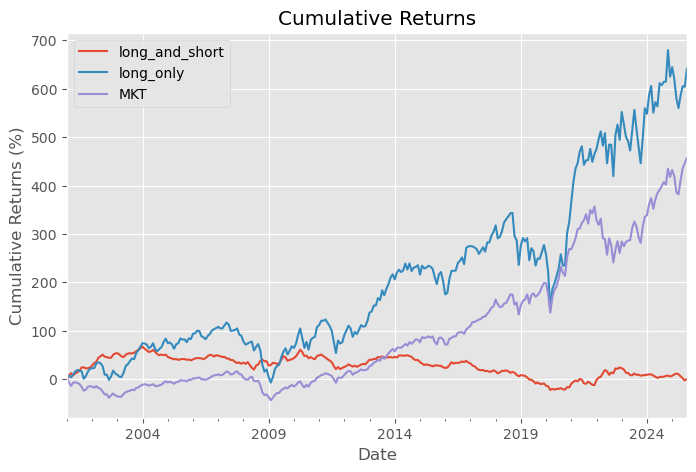

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
(100 * ((1 + temp[mom_names + ['MKT']].loc[YR_CUTOFF:]).cumprod() -1 )).plot(ax=ax)
ax.set_ylabel('Cumulative Returns (%)')
ax.set_title('Cumulative Returns')

### <span style="color:red">1.4.</span>

In [ ]:
ls_1decile = mom_deciles[f'{TAG_LONG} PRIOR'] - mom_deciles[f'{TAG_SHORT} PRIOR']
ls_3decile = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1)
ls_5decile = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1)

ls_names = ['mom_D1','mom_D3','mom_D5']
temp = ff_factors.copy()
temp[ls_names] = pd.concat([ls_1decile, ls_3decile, ls_5decile], axis=1)
summary = calc_summary_statistics(temp.loc[YR_CUTOFF:, ls_names + [KEY]], annual_factor=ANN_SCALE, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ls_names + [KEY]]
summary['val_corr'] = temp.corr().loc['HML', ls_names + [KEY]]
summary.style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
mom_D1,-1.2%,20.5%,-5.9%,26.8%,20.0%,60.6%
mom_D3,0.1%,12.7%,0.5%,-36.0%,-24.7%,-62.3%
mom_D5,0.7%,8.8%,8.2%,-19.7%,-24.8%,-61.0%
REV,0.5%,10.0%,4.9%,56.9%,23.5%,64.8%


In [ ]:
mom_small = tercile_port[f'SMALL {TAG_LONG}PRIOR'] - tercile_port[f'SMALL {TAG_SHORT}PRIOR']
mom_large = tercile_port[f'BIG {TAG_LONG}PRIOR'] - tercile_port[f'BIG {TAG_SHORT}PRIOR']

mom_size_name = ['Small_stocks','Big_stocks']
temp = ff_factors.copy()
temp[mom_size_name] = pd.concat([mom_small, mom_large], axis=1)
summary = calc_summary_statistics(temp.loc[YR_CUTOFF:, [KEY] + mom_size_name], annual_factor=ANN_SCALE, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', [KEY] + mom_size_name]
summary['val_corr'] = temp.corr().loc['HML', [KEY] + mom_size_name]
summary.rename({'UMD':'All_stocks'}).style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
REV,0.5%,10.0%,4.9%,56.9%,23.5%,64.8%
Small_stocks,1.4%,9.4%,14.8%,66.9%,24.7%,53.5%
Big_stocks,-0.4%,12.6%,-3.4%,73.7%,18.5%,63.5%


(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Correlation matrix (lower triangle)'}>)

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Correlation matrix (lower triangle)'}>)

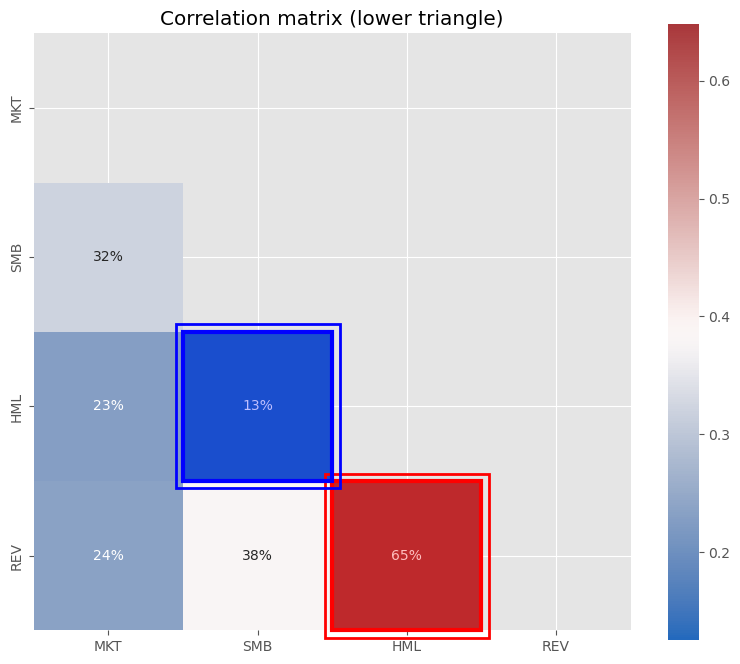

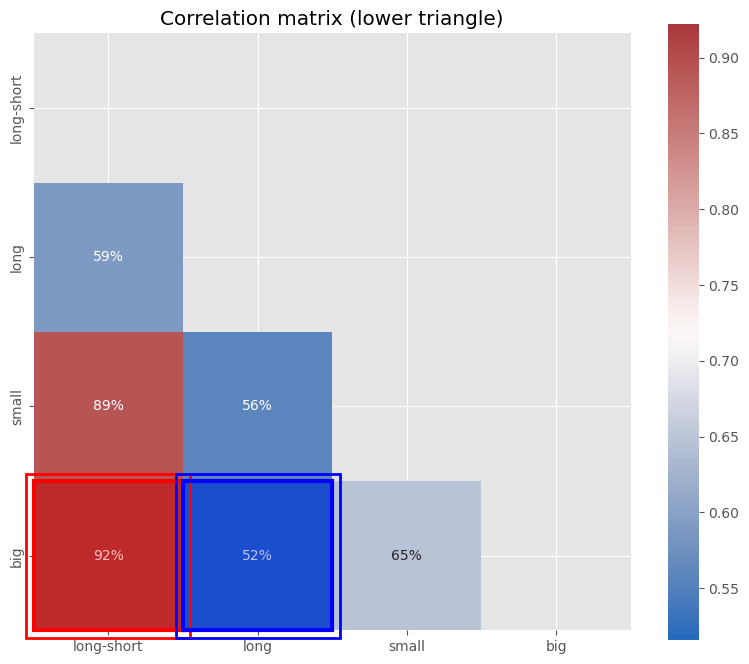

In [ ]:
from cmds.plot_tools import plot_corr_matrix
temp = pd.concat([ff_factors[KEY], mom_long, mom_small, mom_large], axis=1)
temp.columns = ['long-short','long','small','big']

display(plot_corr_matrix(ff_factors,triangle='lower'));
display(plot_corr_matrix(temp,triangle='lower'));

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Correlation matrix (lower triangle)'}>)

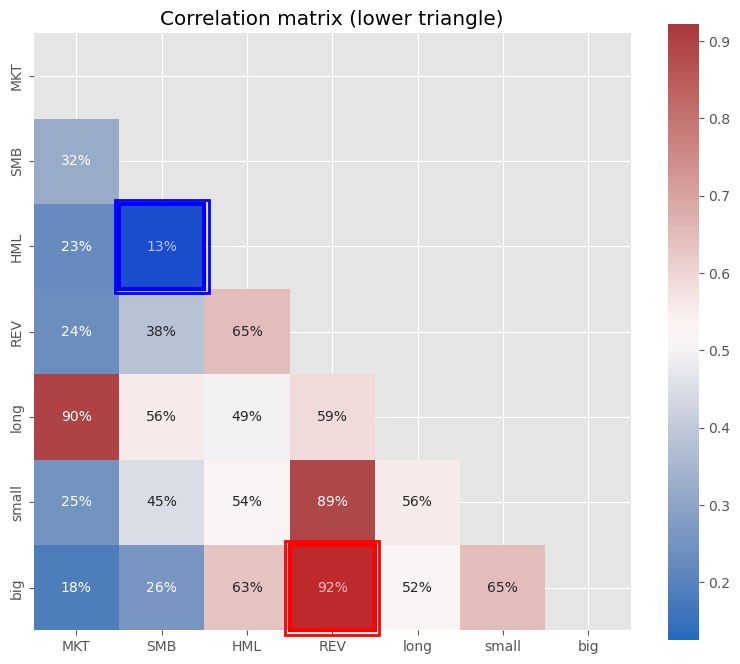

In [ ]:
display(plot_corr_matrix(pd.concat([ff_factors,temp.iloc[:,1:]],axis=1),triangle='lower'));